In [1]:
# # IMPORTS
# astronomy
from astropy.io import fits
# plotting 
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.pyplot as plt
import matplotlib as mpl
# data 
import numpy as np
# file IO
import csv
# my python files 
import match
import v2_AGN_DataAndPlotting as adp
import v2_SED as SED
adp.SetStyle()

# Data

In [2]:
# get data
f = adp.UnpackTable(adp.path_csv+'\\AGN_NH_estimates_Kelly+2024_COSMOS.csv')
for k,v in f.items() :
    if(k == 'ID') : 
        f[k] = np.array(v, dtype=int)
    elif(k == 'GROUP') : 
        f[k] = np.array(v, dtype=str)
    else :
        f[k] = np.array(v, dtype=float)

print(list(f.keys()))

['ID', 'GROUP', 'Z', 'LOG_LIR', 'LOG_LX', 'LOG_LXLIM', 'LOG_LXIR', 'LOG_NH', 'SIG_POS', 'SIG_NEG', 'LOG_NH_COSMOS']


In [3]:
def SplitByColor(dataNew: dict) -> dict : 
    agnInfo = {}
    for color in ['RED', 'GRN', 'BLU'] : 
        idx = np.where(dataNew['GROUP'] == color)

        agnInfo[color] = {}
        for key, val in dataNew.items() : 
            agnInfo[color][key] = val[idx]

    return agnInfo

agnInfo = SplitByColor(f)

In [4]:
def GetNHestimatesWhereCOSMOSisNan(agnInfo) : 

    agnNH_nCOS = {}
    agnNH_yCOS = {} 

    for color, f in agnInfo.items() : 

        maskIsNan = np.isnan(f['LOG_NH_COSMOS'])
        maskIsNotNan = ~maskIsNan

        agnNH_nCOS[color] = {       
            'ID'            : f['ID']           [maskIsNan] ,
            'LOG_NH'        : f['LOG_NH']       [maskIsNan] ,
        }
        agnNH_yCOS[color] = {
            'ID'            : f['ID']           [maskIsNotNan] ,
            'LOG_NH'        : f['LOG_NH']       [maskIsNotNan] ,
            'LOG_NH_COSMOS' : f['LOG_NH_COSMOS'][maskIsNotNan] ,
        }

        print(color, "\t\t(sum: \t", str(len(agnNH_nCOS[color]['ID']) + len(agnNH_yCOS[color]['ID'])), ")")
        print("isNan in COSMOS:\t", len(agnNH_nCOS[color]['ID']))
        print("has COSMOS NH:\t\t",   len(agnNH_yCOS[color]['ID']))
        
        
    return (agnNH_nCOS, agnNH_yCOS)

agnNH_nCOS, agnNH_yCOS = GetNHestimatesWhereCOSMOSisNan(agnInfo)

RED 		(sum: 	 422 )
isNan in COSMOS:	 117
has COSMOS NH:		 305
GRN 		(sum: 	 671 )
isNan in COSMOS:	 180
has COSMOS NH:		 491
BLU 		(sum: 	 1638 )
isNan in COSMOS:	 404
has COSMOS NH:		 1234


# Hists

In [38]:
def AxMakeHist(ax,
    x_red,
    x_grn,
    x_blu,
    bins  : np.array = np.arange(21,25,0.25),
    h     : int = 275
) : 
    
    ax.hist(x_blu, bins=bins, histtype='step', color=adp.c_xray,     linewidth=2)
    ax.hist(x_grn, bins=bins, histtype='step', color=adp.c_ir_xray,  linewidth=2)
    ax.hist(x_red, bins=bins, histtype='step', color=adp.c_ir,       linewidth=2)

    ax.set_ylim(0,h)
    ax.set_xlim(bins[0]-0.25,bins[-1]+0.25)
    ax.xaxis.set_minor_locator(AutoMinorLocator(4))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))

    adp.MeanLineForHist_ax(ax, x=x_red,c=adp.darken_color(adp.c_ir,      1.15), xtext=1.005,ytext=0.94,horizAlign='left',pre='')
    adp.MeanLineForHist_ax(ax, x=x_grn,c=adp.darken_color(adp.c_ir_xray, 1.15), xtext=1.005,ytext=0.94,horizAlign='left',pre='')
    adp.MeanLineForHist_ax(ax, x=x_blu,c=adp.darken_color(adp.c_xray,    1.15), xtext=0.995,ytext=0.94,horizAlign='right',pre='')

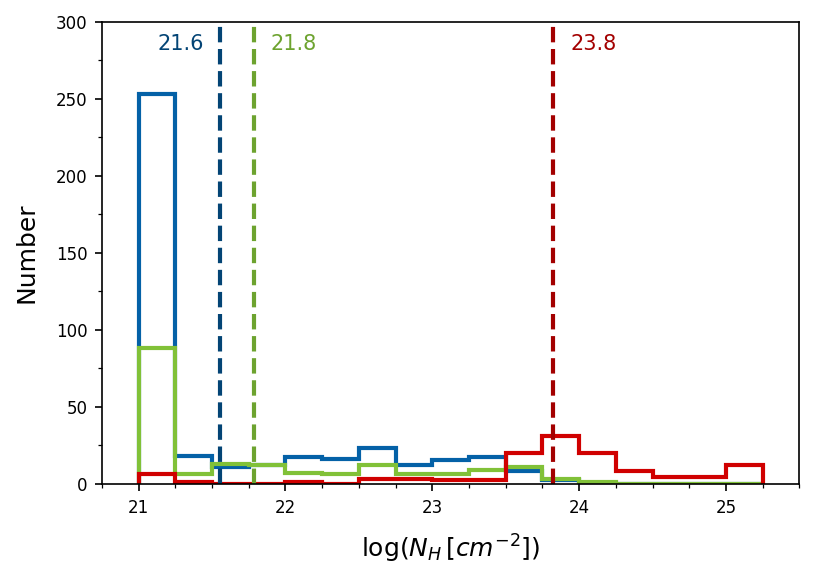

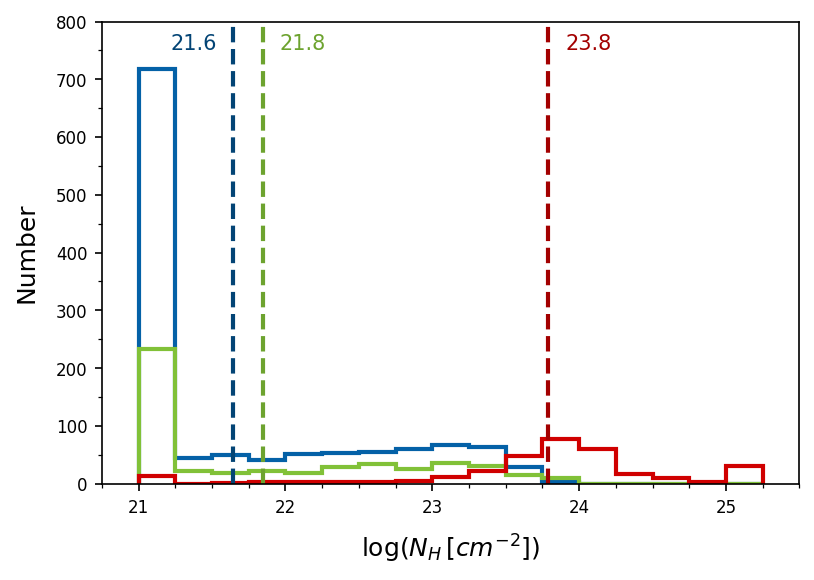

In [39]:
def MakeHist(
    x_red,
    x_grn,
    x_blu,
    bins  : np.array = np.arange(21,25,0.25),
    h     : int = 275,
    save  : str = ''
) : 
    ax = plt.gca()
    AxMakeHist(ax, x_red, x_grn, x_blu, bins , h )

    plt.xlabel('$\log ( N_H \, [cm^{-2}])$')
    plt.ylabel('Number')

    if(save != '') : adp.Save(save)
    plt.show()
    plt.close()
    
MakeHist(    
    x_red = agnNH_nCOS['RED']['LOG_NH'],
    x_grn = agnNH_nCOS['GRN']['LOG_NH'],
    x_blu = agnNH_nCOS['BLU']['LOG_NH'],
    bins  = np.arange(21,25.5,0.25),
    h     = 300,
    save  = adp.path_fig + '\\NHhist_COSMOSisNan_ChisEstim.png'
)

MakeHist(    
    x_red = agnNH_yCOS['RED']['LOG_NH'],
    x_grn = agnNH_yCOS['GRN']['LOG_NH'],
    x_blu = agnNH_yCOS['BLU']['LOG_NH'],
    bins  = np.arange(21,25.5,0.25),
    h     = 800,
    save  = adp.path_fig + '\\NHhist_COSMOSnotNan.png'
)

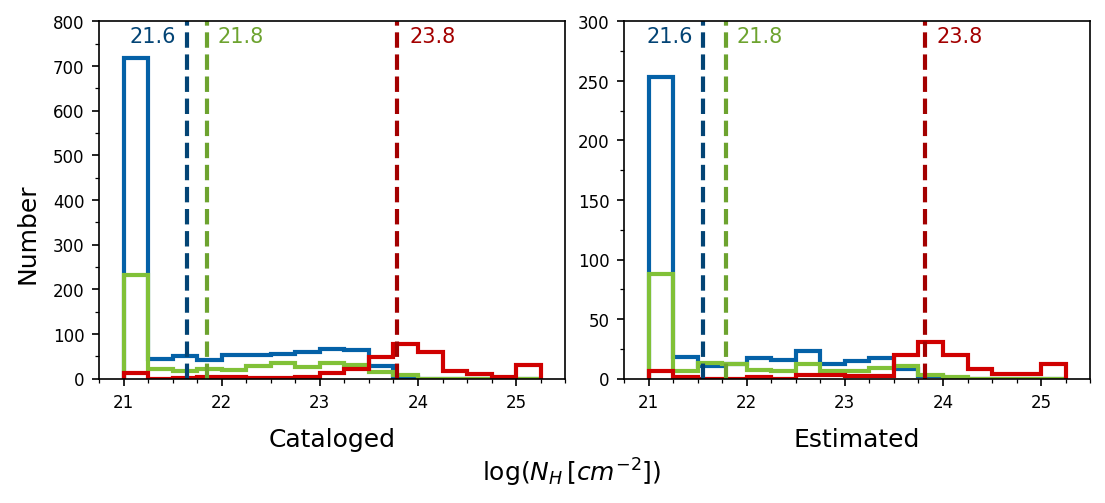

In [40]:
def MoreHists(agnNH_nCOS, agnNH_yCOS, save=''):

    fig, ax = adp.ByZ_SetupFig(2, False, 3, sharex=False, sharey=False)

    x_red = agnNH_yCOS['RED']['LOG_NH']
    x_grn = agnNH_yCOS['GRN']['LOG_NH']
    x_blu = agnNH_yCOS['BLU']['LOG_NH']
    bins  = np.arange(21,25.5,0.25)
    h     = 800
    AxMakeHist(ax[0], x_red, x_grn, x_blu, bins , h )    
    ax[0].set_xlabel('Cataloged')
    
    x_red = agnNH_nCOS['RED']['LOG_NH']
    x_grn = agnNH_nCOS['GRN']['LOG_NH']
    x_blu = agnNH_nCOS['BLU']['LOG_NH']
    bins  = np.arange(21,25.5,0.25)
    h     = 300
    AxMakeHist(ax[1], x_red, x_grn, x_blu, bins , h )
    ax[1].set_xlabel('Estimated')


    xpos=(0.5, -0.05)
    ypos=(-0.03,  0.5)
    adp.ByZ_FinishPlot(
            fig,
            '$\log ( N_H \, [cm^{-2}])$',
            'Number',
            save, xpos, ypos
        )


MoreHists(agnNH_nCOS, agnNH_yCOS, adp.path_fig + '\\NHhist_both.png')